In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Shubham Shaha
- PRN : 240340128031
- Date: 01/06/2024

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
# Some basic parameters
inpDir = '../..\Deep Neural Network\Classwork\input'
outDir = './output'
subDir = 'fashion_mnist'
modelDir = './models'
logDir = './logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 201 # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
REG_LAMBDA = 0.05


PATIENCE = 20
LR_PATIENCE = 10  ## half of patience
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Load Fashion MNIST dataset and visualization

In [4]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [5]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

## Explore the data

In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

## Visualization of data

In [8]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28,28,1])
    label = row[0]
    return feature, label

In [9]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

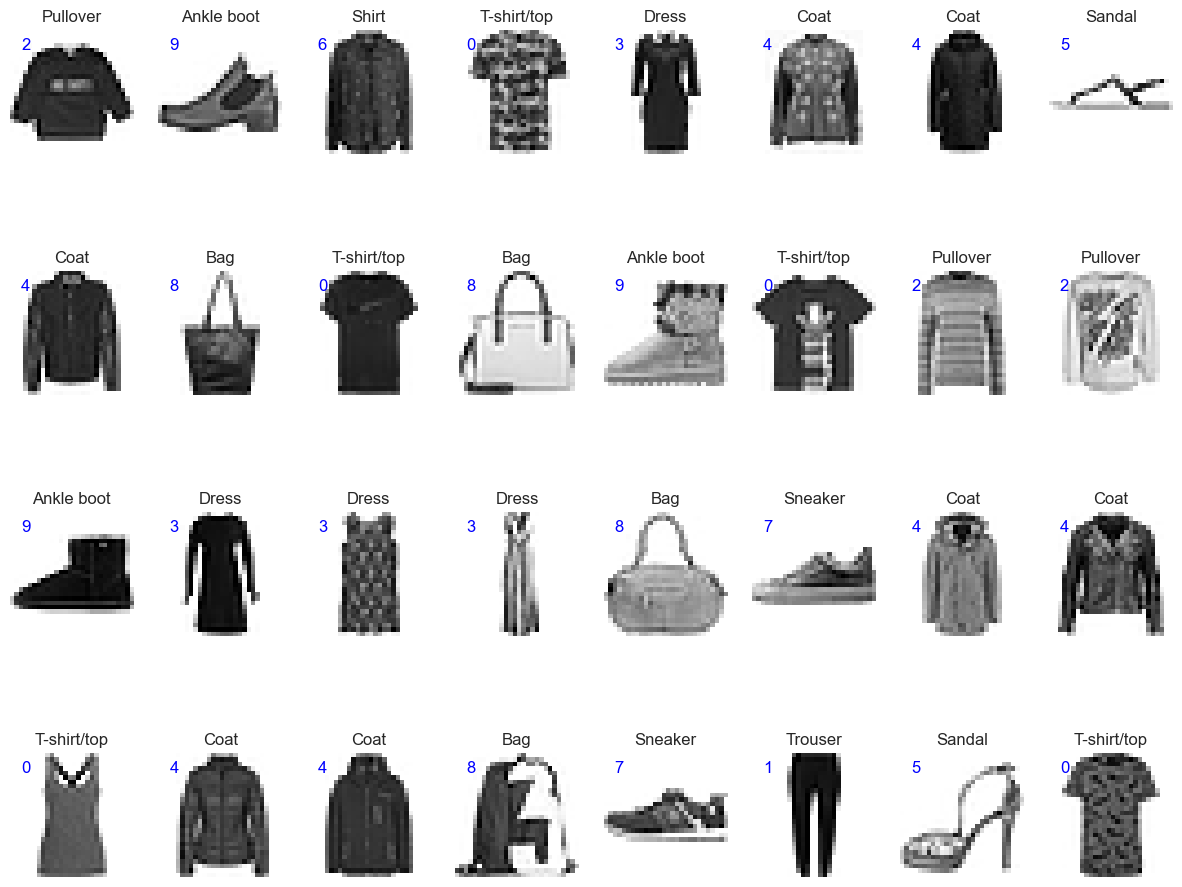

In [10]:
# Sample data plot

fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images, labels in train_ds.take(1):
    
    for i in range (BATCH_SIZE):

        plt.subplot(4,int(BATCH_SIZE//4),i+1) # adjust subplots
    
        plt.imshow(images[i].numpy().astype('uint16'), 
                   cmap=plt.cm.binary, 
                   interpolation='nearest') # show image on the axis
    
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image
        
        plt.axis('off')
    
    plt.show()

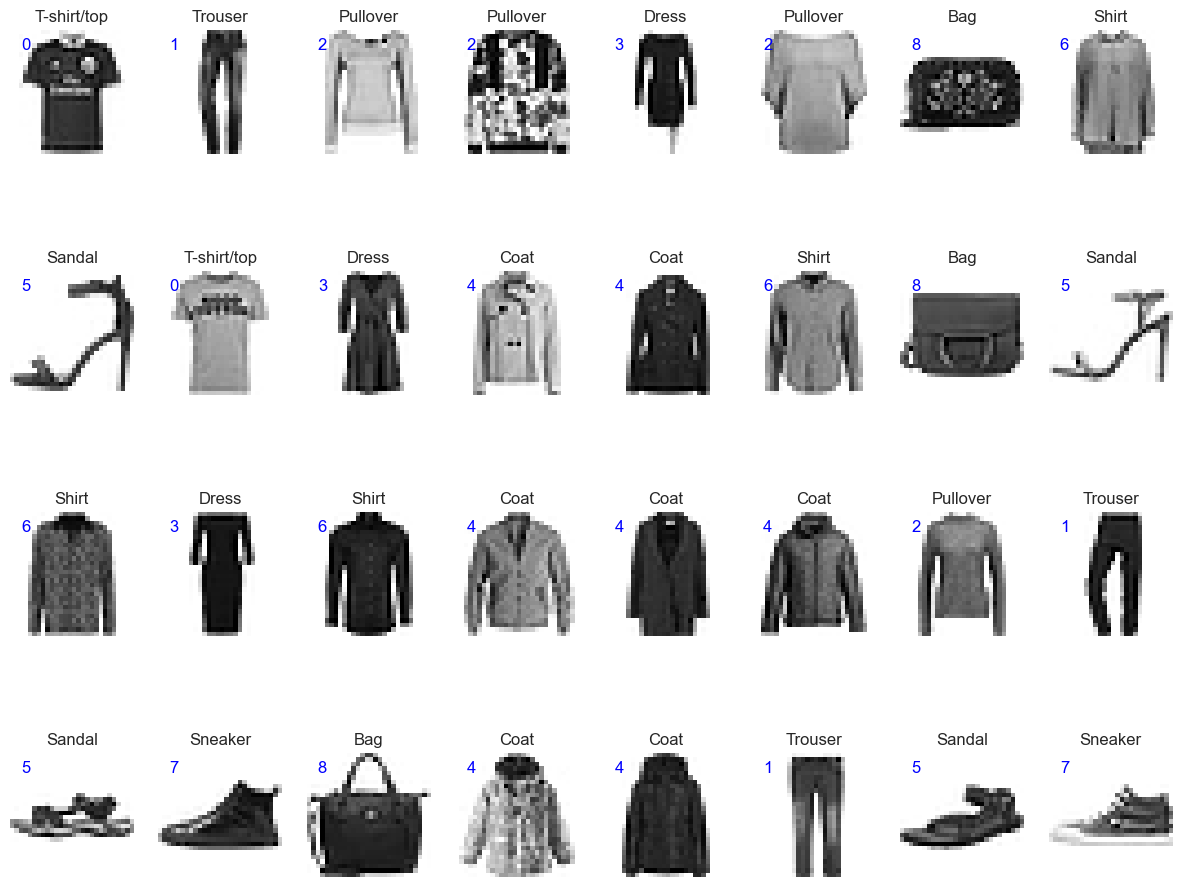

In [11]:
# Sample data plot

fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images, labels in test_ds.take(1):
    
    for i in range (BATCH_SIZE):

        plt.subplot(4,int(BATCH_SIZE//4),i+1) # adjust subplots
    
        plt.imshow(images[i].numpy().astype('uint16'), 
                   cmap=plt.cm.binary, 
                   interpolation='nearest') # show image on the axis
    
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image
        
        plt.axis('off')
    
    plt.show()

## Training and testing feature and labels 

In [12]:
y_train = train_df["label"].to_numpy()

X_train = train_df.drop("label", axis = 1).to_numpy()

y_test = test_df["label"].to_numpy()

X_test = test_df.drop("label", axis = 1).to_numpy()

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (type(X_train),type(y_train),type(X_test),type(y_test))

(60000, 784) (60000,) (10000, 784) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Model Building

In [13]:
## wieght initialization
k_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

## regularization
#k_reg = tf.keras.regularizers.L2(l2 = REG_LAMBDA)
k_reg = None

## Dropouts
drop1 = 0.4
drop2 = 0.3
drop3 = 0.2

model = tf.keras.Sequential([
    ## Scalling
    tf.keras.layers.Rescaling(1./255.),
    
    # input layer
    tf.keras.layers.InputLayer(input_shape = (784,)),
    
    # layer 1
    tf.keras.layers.Dense(198, kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(drop1),
    
    # layer 2
    tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(drop2),
    
    # layer 3
    tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(drop3),
    
    # output layer
    tf.keras.layers.Dense(10)    
])

In [14]:
checkpoint_path = os.path.join(modelDir, subDir, 'weights_tf_FashionMNIST')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0,
)


In [15]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_test,y_test) ,
                    batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=2,
                   callbacks=[model_checkpoint,es_callback,lr_callback]
                   )


Epoch 1/201



Epoch 1: val_loss improved from inf to 0.46865, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 16s - loss: 0.8614 - accuracy: 0.7154 - val_loss: 0.4687 - val_accuracy: 0.8348 - lr: 0.0010 - 16s/epoch - 8ms/step
Epoch 2/201

Epoch 2: val_loss improved from 0.46865 to 0.41211, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 12s - loss: 0.5907 - accuracy: 0.7999 - val_loss: 0.4121 - val_accuracy: 0.8522 - lr: 0.0010 - 12s/epoch - 7ms/step
Epoch 3/201

Epoch 3: val_loss did not improve from 0.41211
1875/1875 - 12s - loss: 0.5345 - accuracy: 0.8164 - val_loss: 0.4549 - val_accuracy: 0.8263 - lr: 0.0010 - 12s/epoch - 6ms/step
Epoch 4/201

Epoch 4: val_loss improved from 0.41211 to 0.37615, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 12s - loss: 0.4998 - accuracy: 0.8281 - val_loss: 0.3761 - val_accuracy: 0.8650 - lr: 0.0010 - 12s/epoch - 7ms/step
Epoch 5/201

Epoch 5: val_loss improved from 

Epoch 35/201

Epoch 35: val_loss did not improve from 0.28603
1875/1875 - 12s - loss: 0.3348 - accuracy: 0.8849 - val_loss: 0.2969 - val_accuracy: 0.8892 - lr: 0.0010 - 12s/epoch - 6ms/step
Epoch 36/201

Epoch 36: val_loss did not improve from 0.28603

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1875/1875 - 11s - loss: 0.3352 - accuracy: 0.8847 - val_loss: 0.2959 - val_accuracy: 0.8937 - lr: 0.0010 - 11s/epoch - 6ms/step
Epoch 37/201

Epoch 37: val_loss improved from 0.28603 to 0.27213, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 10s - loss: 0.3117 - accuracy: 0.8909 - val_loss: 0.2721 - val_accuracy: 0.8999 - lr: 1.0000e-04 - 10s/epoch - 6ms/step
Epoch 38/201

Epoch 38: val_loss improved from 0.27213 to 0.26939, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 11s - loss: 0.3059 - accuracy: 0.8915 - val_loss: 0.2694 - val_accuracy: 0.9017 - lr: 1.0000e-04 - 11s/epoch - 6ms/step
Epoch 39/201

Epo

Epoch 72/201

Epoch 72: val_loss improved from 0.26374 to 0.26312, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 11s - loss: 0.2762 - accuracy: 0.9029 - val_loss: 0.2631 - val_accuracy: 0.9066 - lr: 1.0000e-05 - 11s/epoch - 6ms/step
Epoch 73/201

Epoch 73: val_loss did not improve from 0.26312
1875/1875 - 12s - loss: 0.2756 - accuracy: 0.9032 - val_loss: 0.2640 - val_accuracy: 0.9061 - lr: 1.0000e-05 - 12s/epoch - 6ms/step
Epoch 74/201

Epoch 74: val_loss did not improve from 0.26312
1875/1875 - 11s - loss: 0.2786 - accuracy: 0.9027 - val_loss: 0.2636 - val_accuracy: 0.9067 - lr: 1.0000e-05 - 11s/epoch - 6ms/step
Epoch 75/201

Epoch 75: val_loss did not improve from 0.26312
1875/1875 - 12s - loss: 0.2759 - accuracy: 0.9039 - val_loss: 0.2633 - val_accuracy: 0.9070 - lr: 1.0000e-05 - 12s/epoch - 6ms/step
Epoch 76/201

Epoch 76: val_loss did not improve from 0.26312
1875/1875 - 12s - loss: 0.2781 - accuracy: 0.9034 - val_loss: 0.2646 - val_accuracy: 0.9061 - 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 784)               0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 198)               155430    
                                                                 
 batch_normalization (Batch  (None, 198)               792       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 198)               0         
                                                                 
 dropout (Dropout)           (None, 198)               0         
                                                        

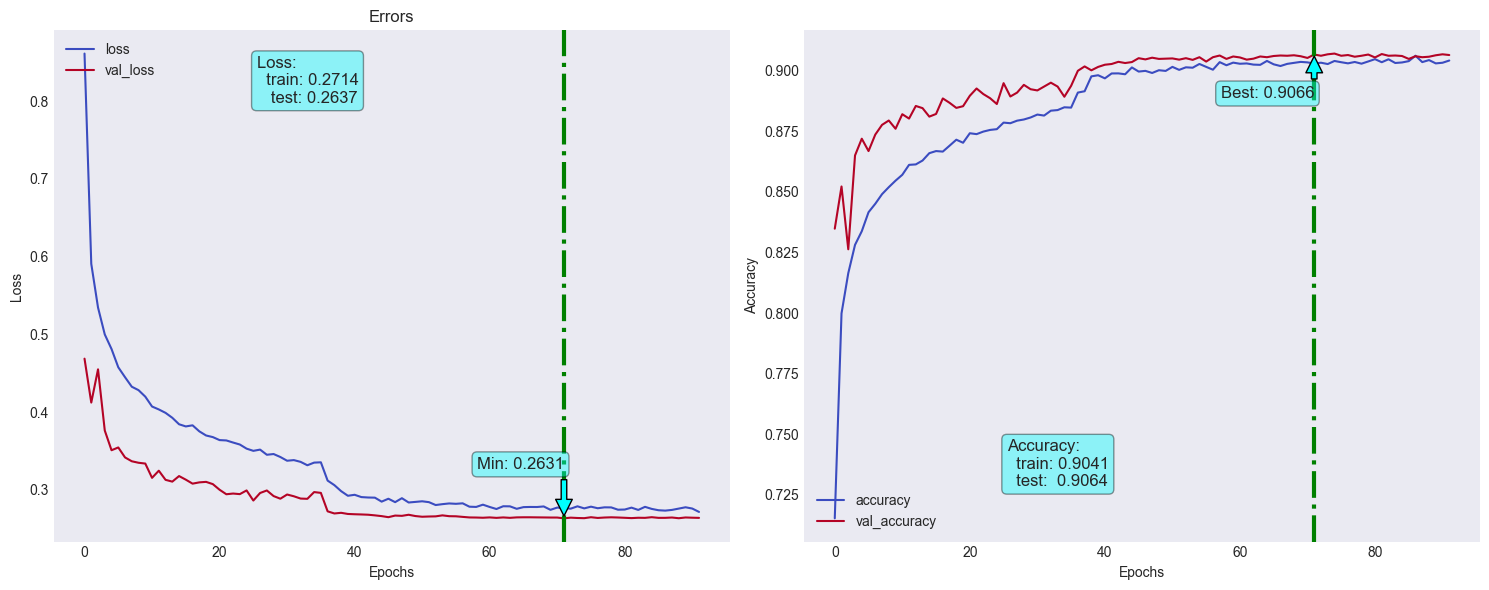

In [17]:
fn_plot_tf_hist(pd.DataFrame(history.history))

313/313 [==============================] - 1s 3ms/step
Test accuracy :  0.9066
classification_report:                precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.87      0.83      0.85      1000
           3       0.91      0.93      0.92      1000
           4       0.85      0.89      0.87      1000
           5       0.99      0.96      0.97      1000
           6       0.76      0.72      0.74      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



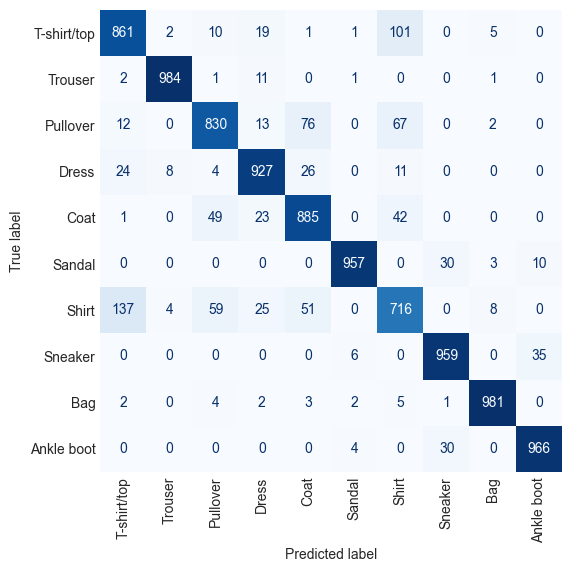

In [18]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print("Test accuracy : ", accuracy_score(y_test,y_pred))
print("classification_report: ", classification_report(y_test,y_pred))
fn_plot_confusion_matrix( y_test, y_pred, labels=class_names)

Results:

1. Base model - 

Test accuracy :  0.8898

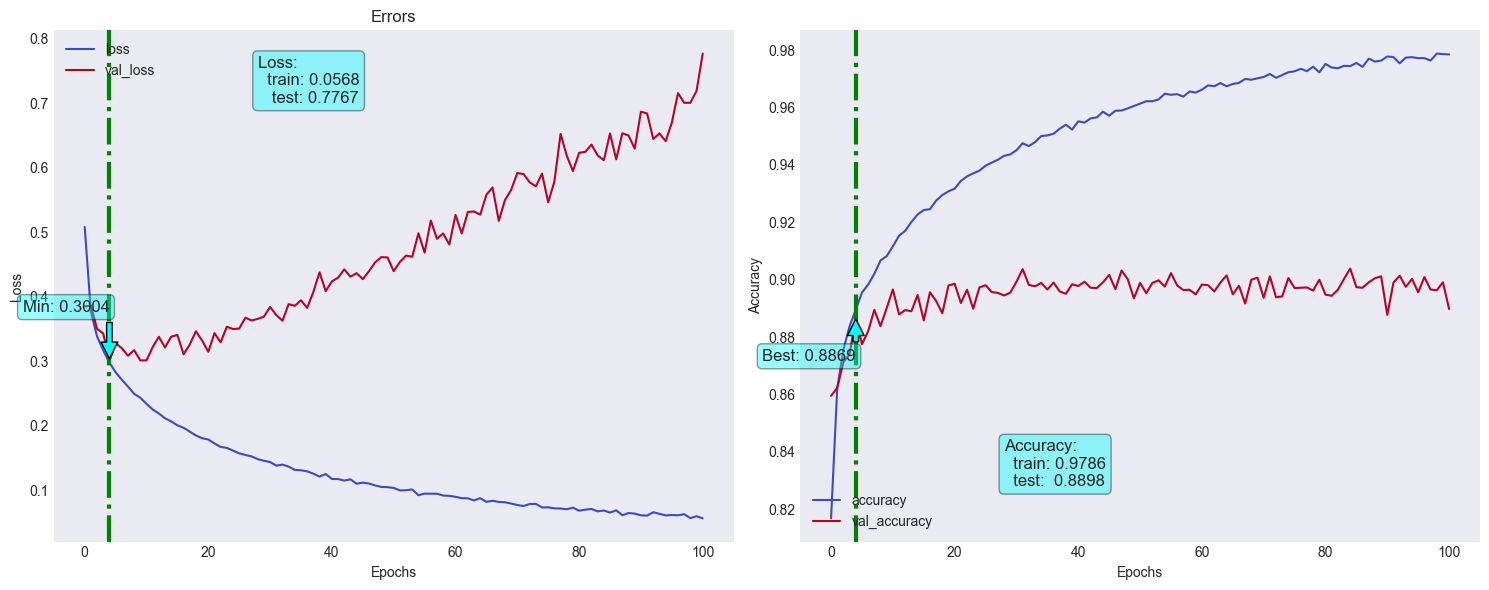


2. L2 regularization - (REG_LAMBDA = 0.05)

Test accuracy :  0.8076

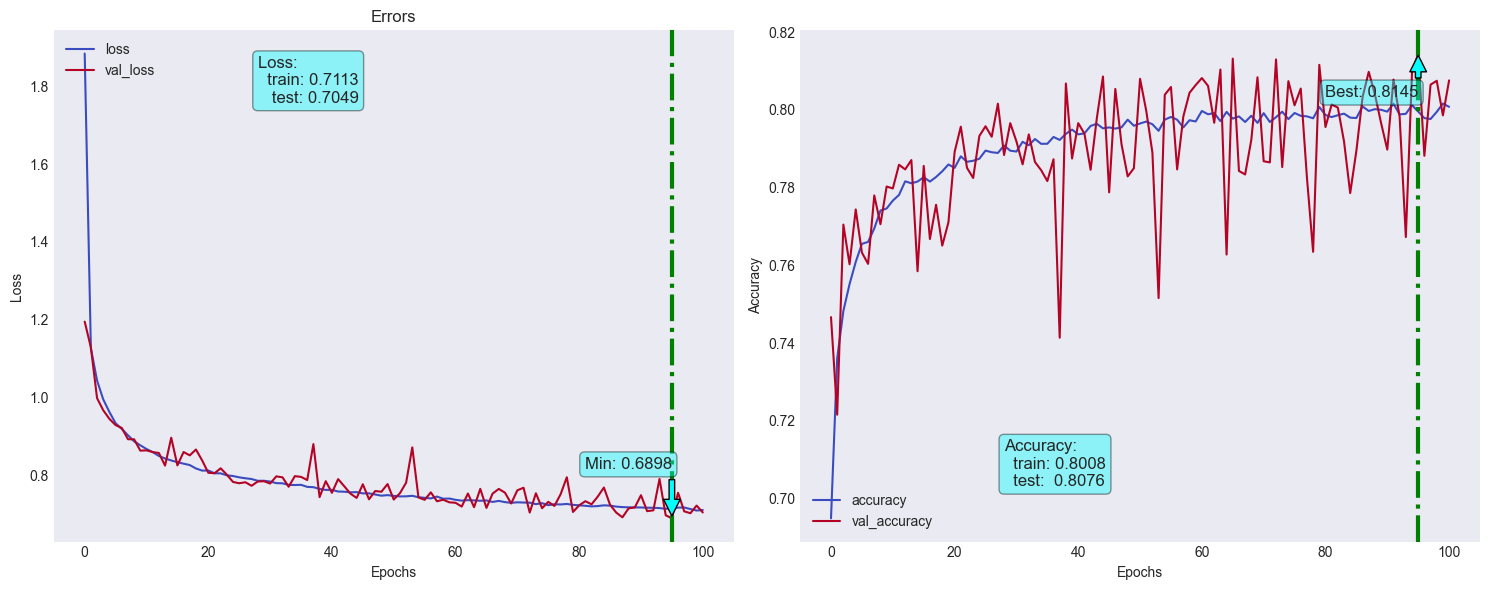

3. Batch Normalization - 

Test accuracy :  0.8924

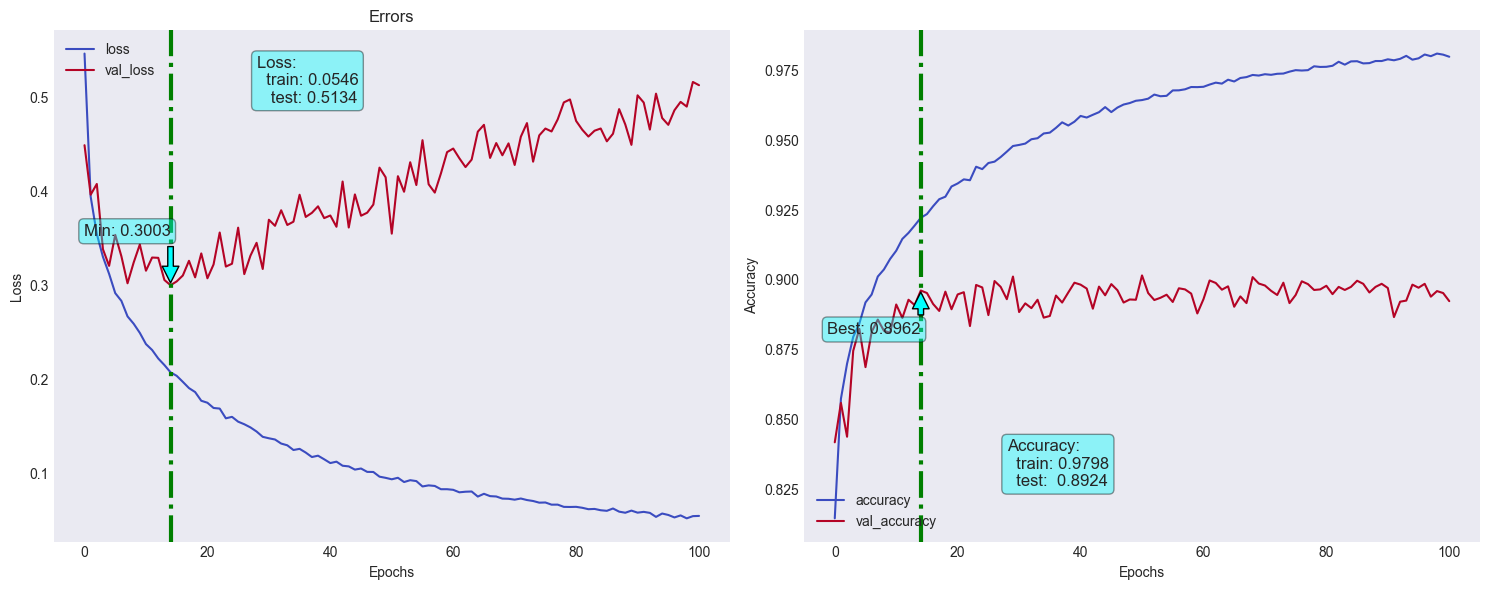

4. Dropouts - 
(drop1 = 0.2
drop2 = 0.3
drop3 = 0.4)

Test accuracy :  0.8983

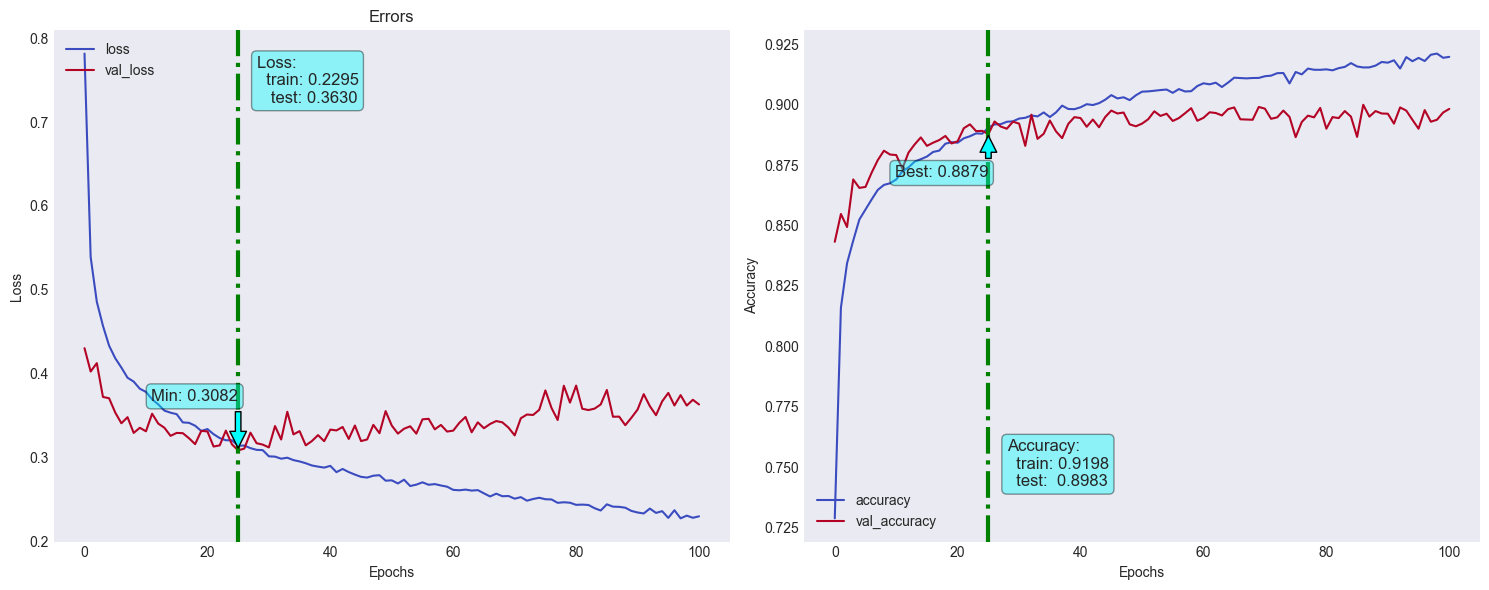

Dropouts -  Gives Better results
(drop1 = 0.4
drop2 = 0.3
drop3 = 0.2)

Test accuracy :  0.8962
    
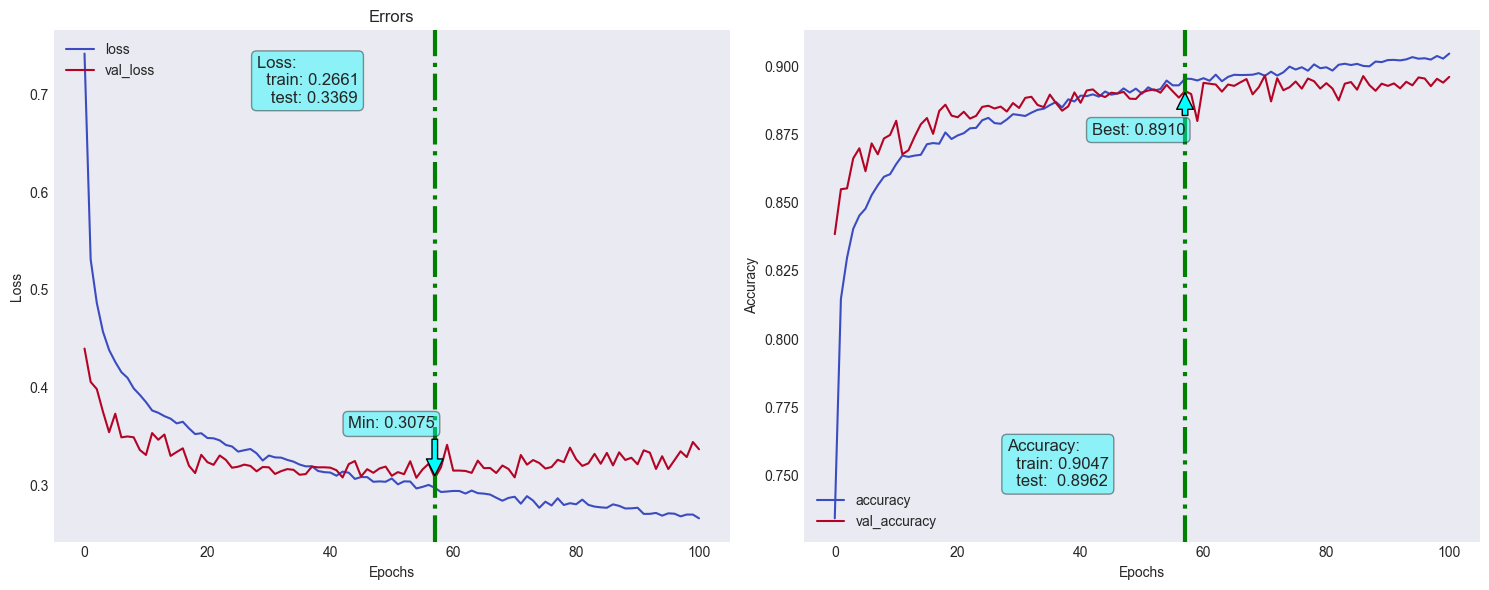   

Dropouts - 
(drop1 = 0.3
drop2 = 0.3
drop3 = 0.3)

Test accuracy :  0.8977

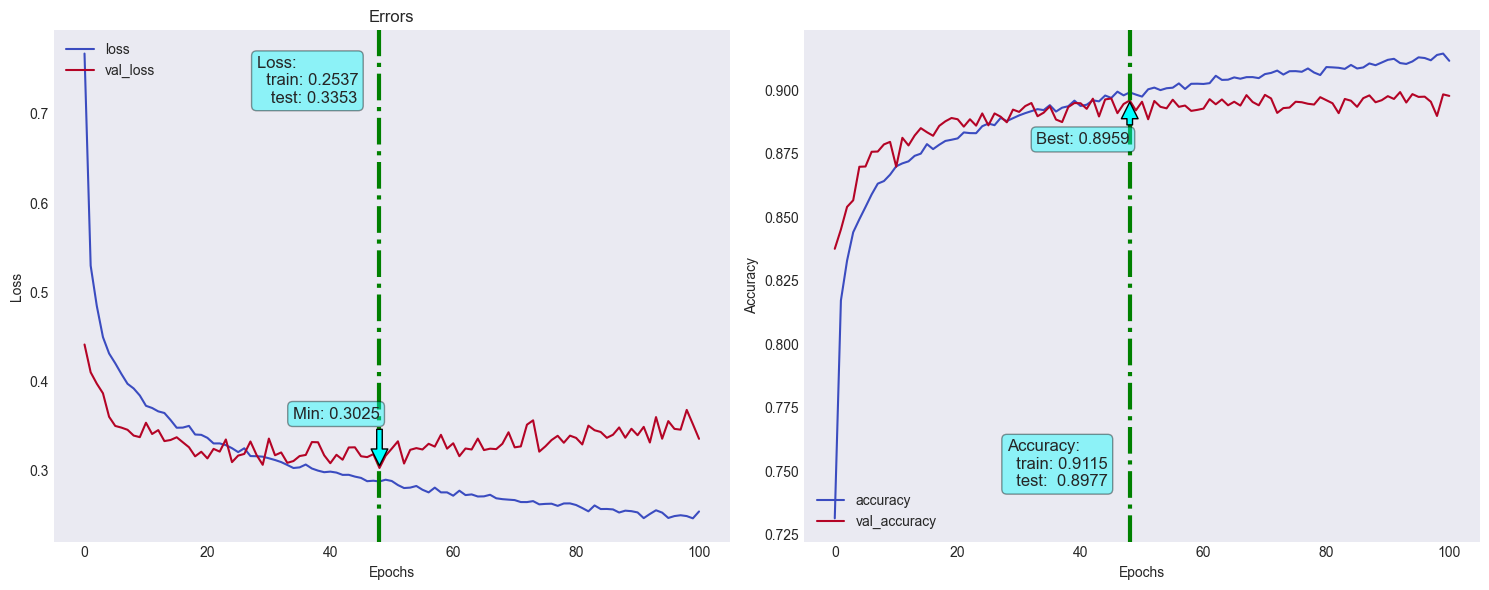

5. Early stopping -
patience 20


Test accuracy :  0.8905

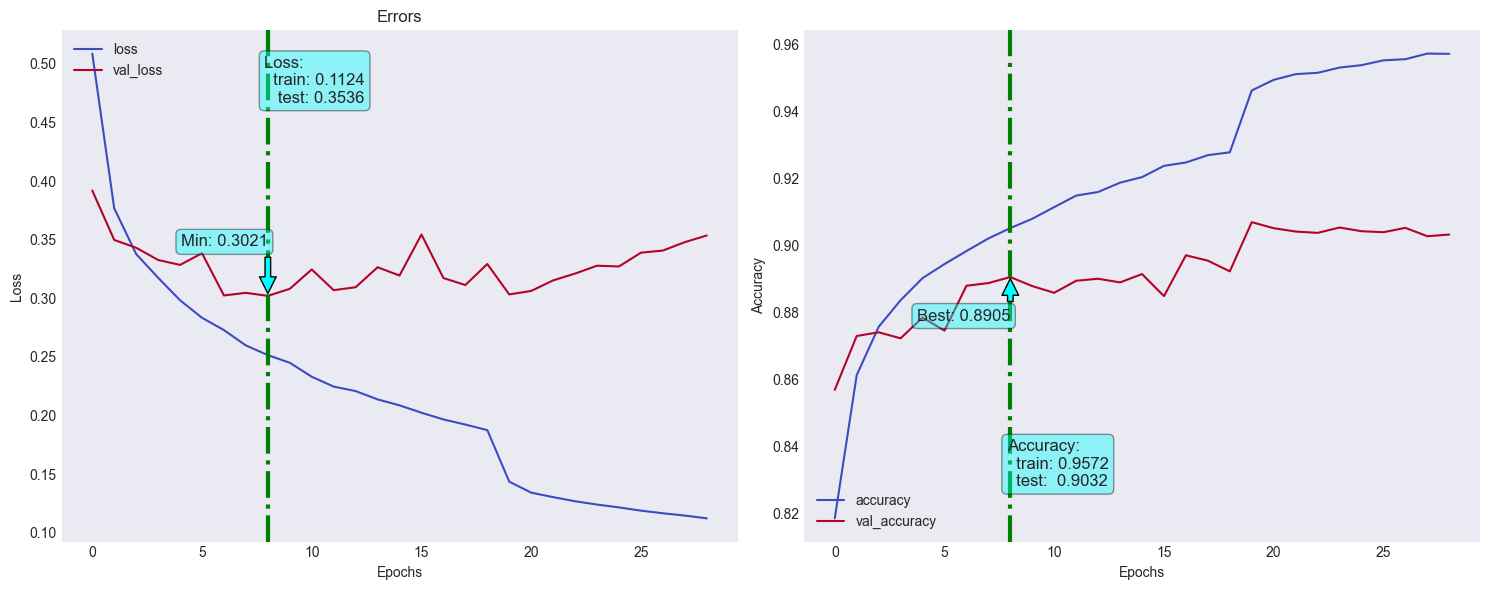

6. Dropouts,  Batch Normalization , early stopping -  

(drop1 = 0.4
drop2 = 0.3
drop3 = 0.2)

patience 20

Test accuracy :  0.9066

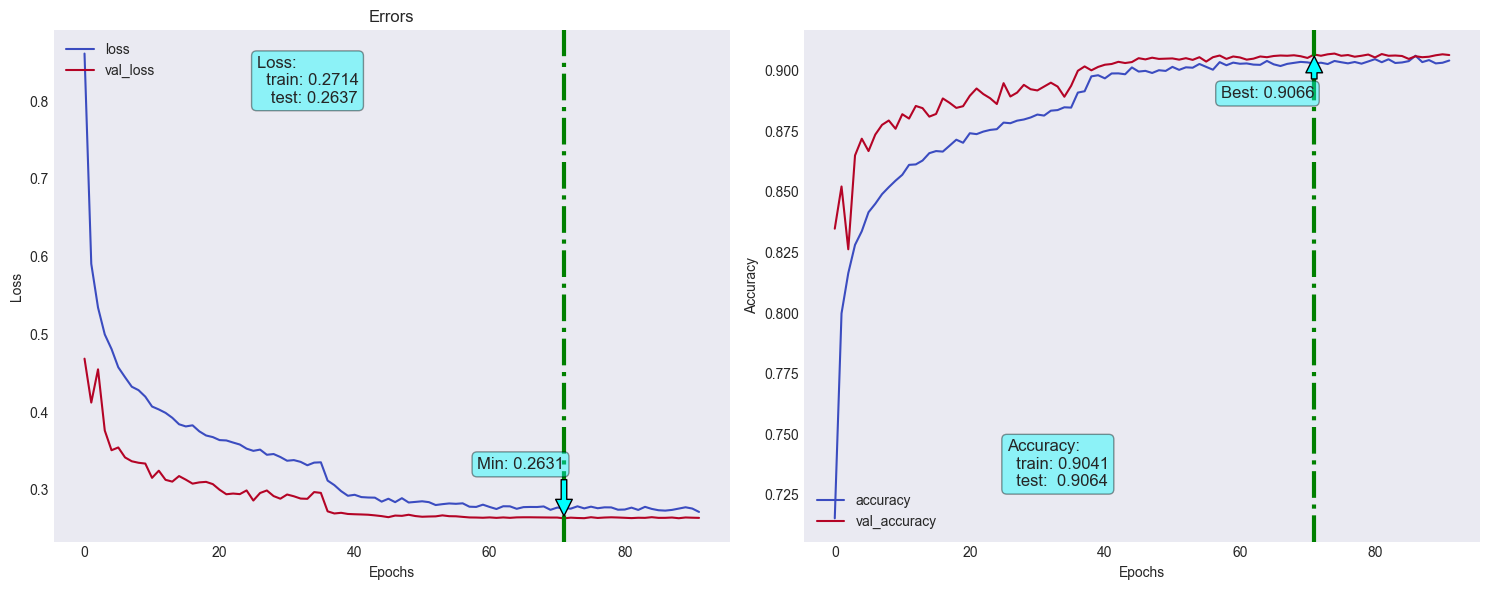